In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Churn rate is a critical metric of customer satisfaction. 
Low churn rates mean happy customers; high churn rates mean customers are leaving you.
The Given problem statment Churn rate is 1 means Person leaving the Services and Churn rate is 0 means customer stay with the service



In [2]:
df = pd.read_csv('wireless_churn.csv')

In [3]:
df.head()

AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  DayMins  \
0           128                1         1        2.7              1    265.1   
1           107                1         1        3.7              1    161.6   
2           137                1         0        0.0              0    243.4   
3            84                0         0        0.0              2    299.4   
4            75                0         0        0.0              3    166.7   

   DayCalls  MonthlyCharge  OverageFee  RoamMins  Churn  
0       110           89.0        9.87      10.0      0  
1       123           82.0        9.78      13.7      0  
2       114           52.0        6.06      12.2      0  
3        71           57.0        3.10       6.6      0  
4       113           41.0        7.42      10.1      0

In [4]:
profile = pp.ProfileReport(df)

In [5]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#Droping Data Usage column because it consist of mostly zeros and it has strong correlation between few independent variables
df = df.drop(['DataUsage'],axis=1)

<AxesSubplot: >

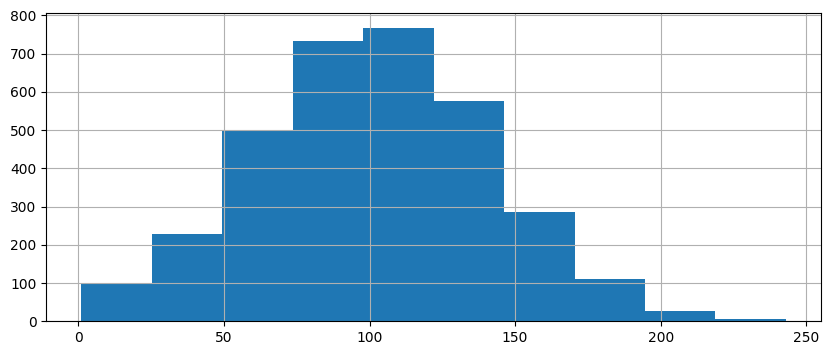

In [7]:

df['AccountWeeks'].hist(figsize=(10,4))

# Outlier detection using Isolation Forest

In [8]:
rng = np.random.RandomState(0)

# Helper function to train and predict IF model for a feature
def train_and_predict_if(df, feature):
    clf = IsolationForest(max_samples=100, random_state=rng)
    clf.fit(df[[feature]])
    pred = clf.predict(df[[feature]])
    scores = clf.decision_function(df[[feature]])
    stats = pd.DataFrame()
    stats['val'] = df[feature]
    stats['score'] = scores
    stats['outlier'] = pred 
    stats['min'] = df[feature].min()
    stats['max'] = df[feature].max()
    stats['mean'] = df[feature].mean()
    stats['median'] = df[feature].median()
    stats['feature'] = [feature] * len(df)
    return stats

# Helper function to print outliers
def print_outliers(df, feature, n):
    print(feature)
    print(df[feature].head(n).to_string(), "\n")

# Run through all features and save the outlier scores for each feature
num_columns = [i for i in list(df.columns) if i not in list(df.select_dtypes('object').columns) and i not in ['Churn']]
result = pd.DataFrame()
for feature in num_columns:
    stats = train_and_predict_if(df, feature)
    result = pd.concat([result, stats])
    
# Gather top outliers for each feature
outliers = {team:grp.drop('feature', axis=1) 
       for team, grp in result.sort_values(by='score').groupby('feature')}

# Print the top 10 outlier samples for a few selected features
n_outliers = 10
print_outliers(outliers, "AccountWeeks", n_outliers)
print_outliers(outliers, "RoamMins", n_outliers)
print_outliers(outliers, "DayMins", n_outliers)
print_outliers(outliers, "DayCalls", n_outliers)
print_outliers(outliers, "OverageFee", n_outliers)
print_outliers(outliers, "MonthlyCharge", n_outliers)


AccountWeeks
        val     score  outlier  min    max        mean  median
817   243.0 -0.246474       -1  1.0  243.0  101.064806   101.0
1408  232.0 -0.246474       -1  1.0  243.0  101.064806   101.0
416   224.0 -0.245856       -1  1.0  243.0  101.064806   101.0
1551  225.0 -0.245856       -1  1.0  243.0  101.064806   101.0
1751  225.0 -0.245856       -1  1.0  243.0  101.064806   101.0
1886  224.0 -0.245856       -1  1.0  243.0  101.064806   101.0
3216  221.0 -0.244621       -1  1.0  243.0  101.064806   101.0
2277  217.0 -0.244621       -1  1.0  243.0  101.064806   101.0
1045  217.0 -0.244621       -1  1.0  243.0  101.064806   101.0
238   215.0 -0.242772       -1  1.0  243.0  101.064806   101.0 

RoamMins
      val     score  outlier  min   max       mean  median
2513  0.0 -0.271999       -1  0.0  20.0  10.237294    10.3
878   0.0 -0.271999       -1  0.0  20.0  10.237294    10.3
2918  0.0 -0.271999       -1  0.0  20.0  10.237294    10.3
2345  0.0 -0.271999       -1  0.0  20.0  10.237

# Clipping outlier points to fall nearest to the datapoints

In [9]:
df.RoamMins= df.RoamMins.clip(1.86,18)
df.DayMins= df.DayMins.clip(16,343)
df.MonthlyCharge= df.MonthlyCharge.clip(7,105)
df.DayCalls= df.DayCalls.clip(40,160)
df.AccountWeeks= df.AccountWeeks.clip(18,220)
df.OverageFee= df.OverageFee.clip(2,17)

In [10]:
#one hot encoding for customer calls feature
one_hot = pd.get_dummies(df['CustServCalls'],prefix='CustServCalls')
df = df.drop('CustServCalls',axis = 1)
# Join the encoded df
df = df.join(one_hot)
df 

AccountWeeks  ContractRenewal  DataPlan  DayMins  DayCalls  \
0              128                1         1    265.1       110   
1              107                1         1    161.6       123   
2              137                1         0    243.4       114   
3               84                0         0    299.4        71   
4               75                0         0    166.7       113   
...            ...              ...       ...      ...       ...   
3328           192                1         1    156.2        77   
3329            68                1         0    231.1        57   
3330            28                1         0    180.8       109   
3331           184                0         0    213.8       105   
3332            74                1         1    234.4       113   

      MonthlyCharge  OverageFee  RoamMins  Churn  CustServCalls_0  \
0              89.0        9.87      10.0      0                0   
1              82.0        9.78      13.7      0                0   
2              52.0        6.06      12.2      0                1   
3              57.0        3.10       6.6      0                0   
4              41.0        7.42      10.1      0                0   
...             ...         ...       ...    ...              ...   
3328           71.7       10.78       9.9      0                0   
3329           56.4        7.67       9.6      0                0   
3330           56.0       14.44      14.1      0                0   
3331           50.0        7.98       5.0      0                0   
3332          100.0       13.30      13.7      0                1   

      CustServCalls_1  CustServCalls_2  CustServCalls_3  CustServCalls_4  \
0                   1                0                0                0   
1                   1                0                0                0   
2                   0                0                0                0   
3                   0                1                0                0   
4                   0                0                1                0   
...               ...              ...              ...              ...   
3328                0                1                0                0   
3329                0                0                1                0   
3330                0                1                0                0   
3331                0                1                0                0   
3332                0                0                0                0   

      CustServCalls_5  CustServCalls_6  CustServCalls_7  CustServCalls_8  \
0                   0                0                0                0   
1                   0                0                0                0   
2                   0                0                0                0   
3                   0                0                0                0   
4                   0                0                0                0   
...               ...              ...              ...              ...   
3328                0                0                0                0   
3329                0                0                0                0   
3330                0                0                0                0   
3331                0                0                0                0   
3332                0                0                0                0   

      CustServCalls_9  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
3328                0  
3329                0  
3330                0  
3331                0  
3332                0  

[3333 rows x 19 columns]

In [11]:
#slicing independent features
X = df.drop('Churn',axis=1)
#slicing dependent features
Y = df['Churn']


In [12]:
#split the data for Training and Testing
#70% of data given for training
#30% of data given for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100,stratify=Y)

# Feature scaling

In [13]:
#Feature scaling
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [53]:
#define metrics for comparing models
model_validations = {'LogisticRegression': {'Model Accuracy':'','Model Recall score':''},'Naive Bayes': {'Model Accuracy':'','Model Recall score':''},'Adaboost': {'Model Accuracy':'','Model Recall score':''},'votingclassifier':{'Model Accuracy':'','Model Recall score':''}}

# Logistic Regression

In [15]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000,random_state=100)
result = model.fit(X_train, y_train)
prediction_test = result.predict(X_test)
# Print the prediction accuracy
print(recall_score(y_test, prediction_test, average='weighted'))
print(f'Confusion Matrix: \n{confusion_matrix(y_test, prediction_test)}')
print(classification_report(y_test, prediction_test))

0.854
Confusion Matrix: 
[[728 127]
 [ 19 126]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       855
           1       0.50      0.87      0.63       145

    accuracy                           0.85      1000
   macro avg       0.74      0.86      0.77      1000
weighted avg       0.91      0.85      0.87      1000



# Plot Learning curve

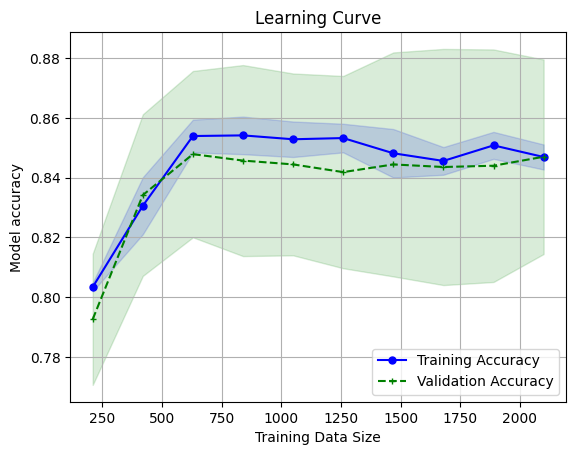

In [16]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train,scoring="recall_weighted",
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1)
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

# Logistic Regression Optimizied Model

In [54]:
#Hyperparameter tuning
lr=LogisticRegression()
#tuning weight for minority class then weight for majority class will be 1-weight of minority class
#Setting the range for class weights
weights = np.linspace(0.0,0.99,500)
#specifying all hyperparameters with possible values
param= {'solver': ['newton-cg','lbfgs','sag','saga'],'C': [0.01,0.001,0.1, 0.5, 1,10,15,20], 'penalty': ['l1', 'l2',''],"class_weight":['balanced']}
# create 5 folds
folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
#Gridsearch for hyperparam tuning
model_l= GridSearchCV(estimator= lr,param_grid=param,scoring="recall_weighted",cv=folds,return_train_score=True)
#train model to learn relationships between x and y
model_l.fit(X_train,y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.001, 0.1, 0.5, 1, 10, 15, 20],
                         'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2', ''],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             return_train_score=True, scoring='recall_weighted')

In [55]:
print("Best recall score: ", model_l.best_score_)
print("Best hyperparameters: ", model_l.best_params_)

Best recall score:  0.8564340999963317
Best hyperparameters:  {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}


# Adjusting Best Hyper parameters to Logistice Regression model

0.8482758620689655
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       855
           1       0.51      0.85      0.64       145

    accuracy                           0.86      1000
   macro avg       0.74      0.86      0.78      1000
weighted avg       0.90      0.86      0.87      1000



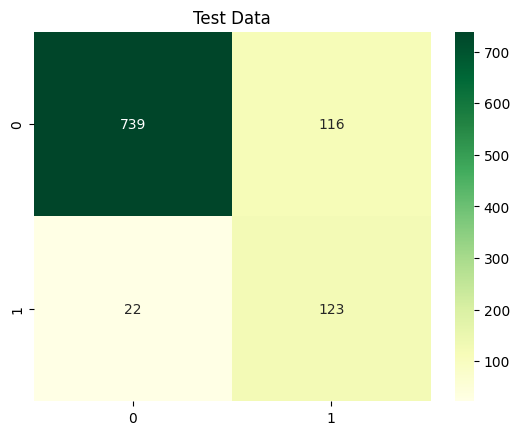

In [56]:
optimized_model = LogisticRegression(solver = 'newton-cg',class_weight='balanced',C=0.001,penalty="l2",random_state=100)
result1 = optimized_model.fit(X_train, y_train)
prediction_test = result1.predict(X_test)
# Print the roc score
recall = recall_score(y_test, prediction_test)
print(recall)
accuracy = accuracy_score(y_test, prediction_test)
print(classification_report(y_test, prediction_test))
recall = recall_score(y_test, prediction_test)
sns.heatmap((metrics.confusion_matrix(y_test,prediction_test)),annot=True,fmt='.5g',cmap="YlGn").set_title('Test Data');

# Plot ROC/AUC Curve

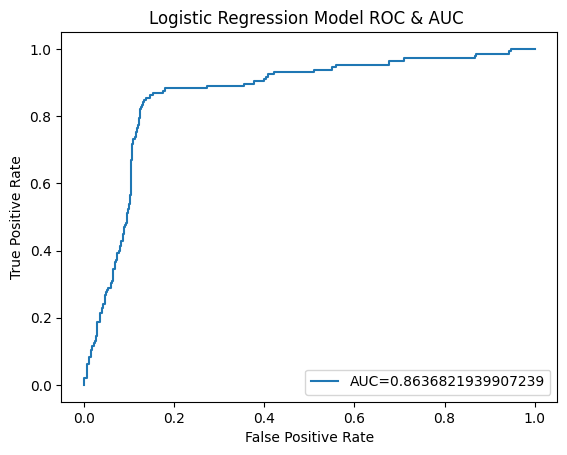

In [57]:
#define metrics
y_pred_proba = result1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.title('Logistic Regression Model ROC & AUC ')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Plot Learning Curve

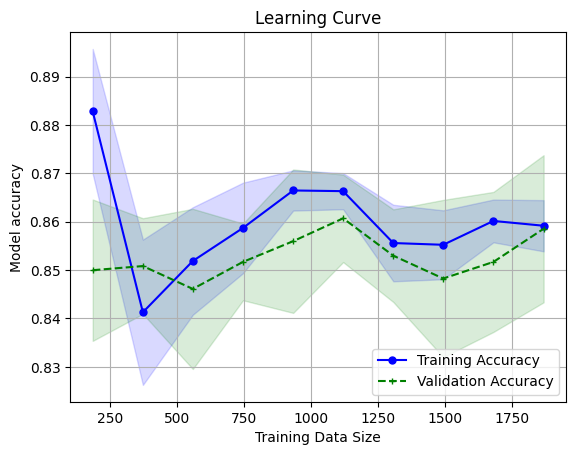

In [58]:
train_sizes, train_scores, test_scores = learning_curve(estimator=optimized_model, X=X_train, y=y_train,scoring="recall_weighted",
                                                       cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1)
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [59]:
model_validations['LogisticRegression']['Model Accuracy'] = accuracy
model_validations['LogisticRegression']['Model Recall score'] = recall
model_validations['LogisticRegression']['ROC/AUC score'] = auc

# Naive Bayes

In [26]:
classifier = GaussianNB()  
naive = classifier.fit(X_train, y_train)  
predict_naive = naive.predict(X_test)
# Print the prediction accuracy
print(f'Confusion Matrix: \n{confusion_matrix(y_test, predict_naive)}')
print(classification_report(y_test, predict_naive))
print(recall_score(y_test, predict_naive, average='weighted'))

Confusion Matrix: 
[[841  14]
 [122  23]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.93       855
           1       0.62      0.16      0.25       145

    accuracy                           0.86      1000
   macro avg       0.75      0.57      0.59      1000
weighted avg       0.84      0.86      0.83      1000

0.864


# Naive Bayes Learning Curve

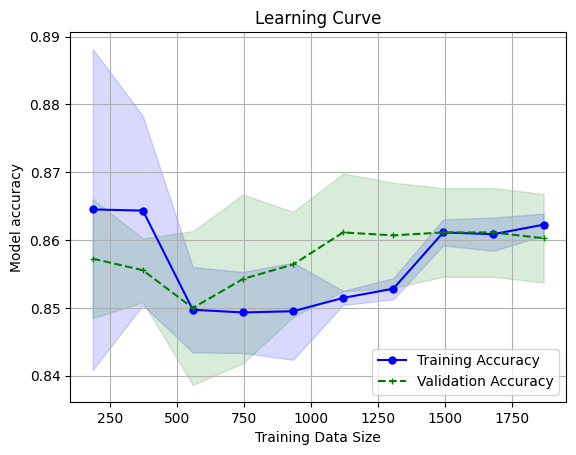

In [27]:
train_sizes, train_scores, test_scores = learning_curve(estimator=classifier, X=X_train, y = y_train,scoring="recall_weighted",
                                                       cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1)
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

# Naives Bayes optimization using Hyper parameter tuning

In [60]:
nb_classifier = GaussianNB()
folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=folds,   # use any cross validation technique 
                 verbose=1, 
                 scoring='recall_weighted') 
Data_transformed = PowerTransformer().fit_transform(X)
gs_NB.fit(Data_transformed, Y)

gs_NB.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


{'var_smoothing': 0.657933224657568}

Confusion Matrix: 
[[839  16]
 [119  26]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       855
           1       0.62      0.18      0.28       145

    accuracy                           0.86      1000
   macro avg       0.75      0.58      0.60      1000
weighted avg       0.84      0.86      0.83      1000

0.1793103448275862


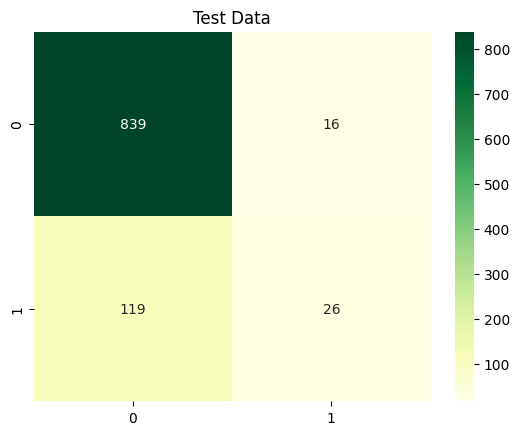

In [61]:
classifier = GaussianNB(var_smoothing= 0.657933224657568)  
naive1 = classifier.fit(X_train, y_train)  
predict_naive1 = naive1.predict(X_test)
# Print the prediction accuracy
print(f'Confusion Matrix: \n{confusion_matrix(y_test, predict_naive1)}')
print(classification_report(y_test, predict_naive1))
recall = recall_score(y_test, predict_naive1)
print(recall)

accuracy = accuracy_score(y_test, predict_naive1)
sns.heatmap((metrics.confusion_matrix(y_test,predict_naive1)),annot=True,fmt='.5g',cmap="YlGn").set_title('Test Data');

# Learning Curve

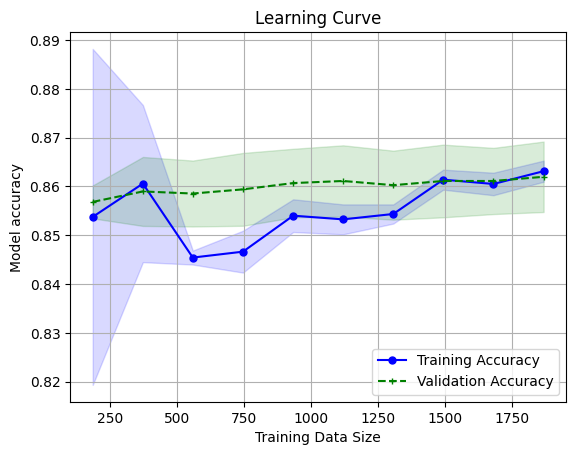

In [31]:
train_sizes, train_scores, test_scores = learning_curve(estimator=naive1, X=X_train, y=y_train,scoring="recall_weighted",
                                                       cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1)
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt

plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

# ROC/AUC Curve

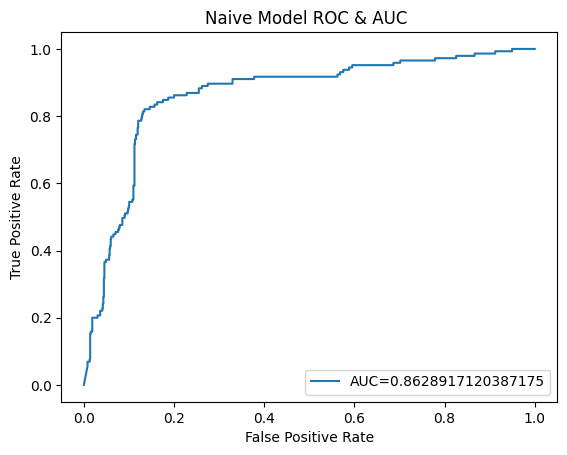

In [62]:
#define metrics
y_pred_proba = naive1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.title('Naive Model ROC & AUC ')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [63]:
model_validations['Naive Bayes']['Model Accuracy'] = accuracy
model_validations['Naive Bayes']['Model Recall score'] = recall
model_validations['Naive Bayes']['ROC/AUC score'] = auc

# Boosting Technique Adaboost

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       855
           1       0.67      0.38      0.48       145

    accuracy                           0.88      1000
   macro avg       0.79      0.67      0.71      1000
weighted avg       0.87      0.88      0.87      1000

0.3793103448275862


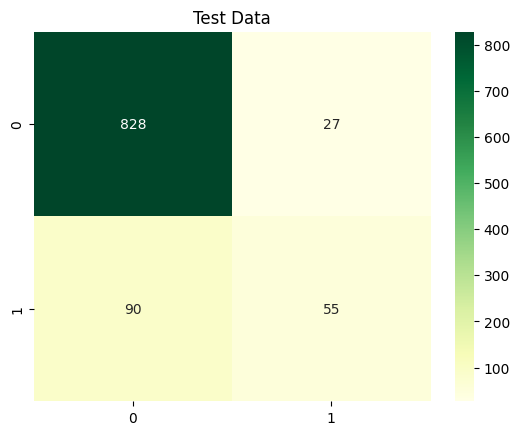

In [64]:
# Create adaboost classifer object
abc = AdaBoostClassifier()
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)
sns.heatmap((metrics.confusion_matrix(y_test,y_pred)),annot=True,fmt='.5g',cmap="YlGn").set_title('Test Data');
print(classification_report(y_test, y_pred))
recall = recall_score(y_test, y_pred)
print(recall)
accuracy = accuracy_score(y_test, y_pred)

# Learning Curve

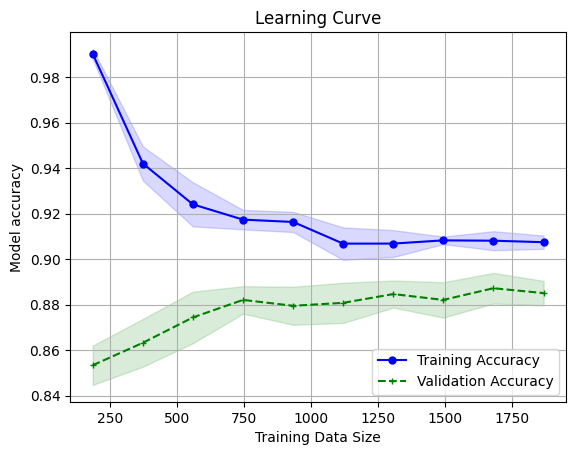

In [35]:
train_sizes, train_scores, test_scores = learning_curve(estimator=abc, X=X_train, y=y_train,scoring="recall_weighted",
                                                       cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1)
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

# ROC/AUC Curve

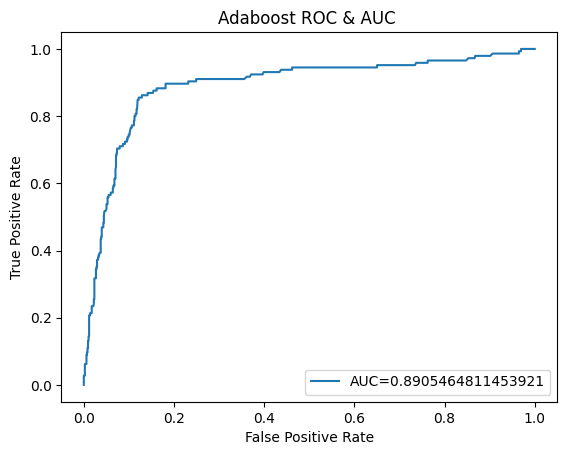

In [65]:
#define metrics
y_pred_proba = abc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.title('Adaboost ROC & AUC ')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [66]:
model_validations['Adaboost']['Model Accuracy'] = accuracy
model_validations['Adaboost']['Model Recall score'] = recall
model_validations['Adaboost']['ROC/AUC score'] = auc

In [98]:
from sklearn.ensemble import VotingClassifier
estimator = []
estimator.append(('LR',optimized_model))
estimator.append(('Adaboost',abc))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       855
           1       0.54      0.83      0.65       145

    accuracy                           0.87      1000
   macro avg       0.75      0.86      0.79      1000
weighted avg       0.91      0.87      0.88      1000

0.8344827586206897


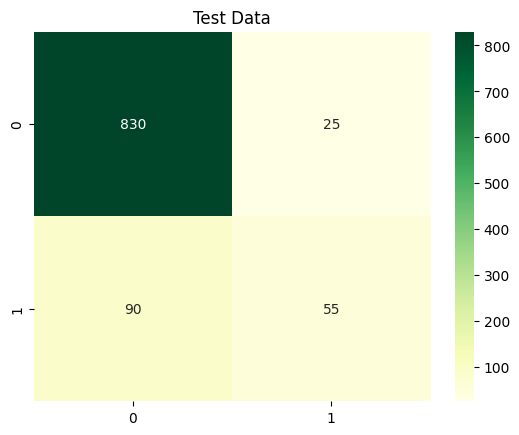

In [99]:
vot_hard = VotingClassifier(estimators = estimator, voting ='soft') #majority vote
vot_hard.fit(X_train, y_train)
y_prede = vot_hard.predict(X_test)
sns.heatmap((metrics.confusion_matrix(y_test,y_pred)),annot=True,fmt='.5g',cmap="YlGn").set_title('Test Data');
print(classification_report(y_test, y_prede))
recall = recall_score(y_test, y_prede)
print(recall)
accuracy = accuracy_score(y_test, y_prede)

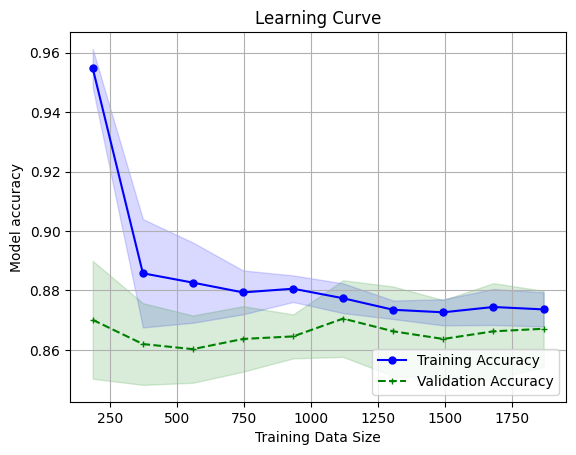

In [103]:
train_sizes, train_scores, test_scores = learning_curve(estimator=vot_hard, X=X_train, y=y_train,scoring="recall_weighted",
                                                       cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1)
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [100]:
model_validations['votingclassifier']['Model Accuracy'] = accuracy
model_validations['votingclassifier']['Model Recall score'] = recall
model_validations['votingclassifier']['ROC/AUC score'] = auc

In [101]:
validation = pd.DataFrame(model_validations)

In [102]:
validation.T

Model Accuracy  Model Recall score  ROC/AUC score
LogisticRegression           0.862            0.848276       0.863682
Naive Bayes                  0.865            0.179310       0.862892
Adaboost                     0.883            0.379310       0.890546
votingclassifier             0.872            0.834483       0.890546